# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            #nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            #nn.Tanh(),
            nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            #nn.Tanh(),
            nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): SELU()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): SELU()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): SELU()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/25, Loss: 0.1693
Epoch 1/200, Iteration 2/25, Loss: 3.6740
Epoch 1/200, Iteration 3/25, Loss: 6.8422
Epoch 1/200, Iteration 4/25, Loss: 4.1914
Epoch 1/200, Iteration 5/25, Loss: 1.5155
Epoch 1/200, Iteration 6/25, Loss: 1.1740
Epoch 1/200, Iteration 7/25, Loss: 1.7319
Epoch 1/200, Iteration 8/25, Loss: 1.6483
Epoch 1/200, Iteration 9/25, Loss: 1.3821
Epoch 1/200, Iteration 10/25, Loss: 0.6839
Epoch 1/200, Iteration 11/25, Loss: 1.0217
Epoch 1/200, Iteration 12/25, Loss: 1.1178
Epoch 1/200, Iteration 13/25, Loss: 0.5910
Epoch 1/200, Iteration 14/25, Loss: 0.7092
Epoch 1/200, Iteration 15/25, Loss: 0.3701
Epoch 1/200, Iteration 16/25, Loss: 0.7890
Epoch 1/200, Iteration 17/25, Loss: 0.9317
Epoch 1/200, Iteration 18/25, Loss: 0.5234
Epoch 1/200, Iteration 19/25, Loss: 0.6610
Epoch 1/200, Iteration 20/25, Loss: 0.5303
Epoch 1/200, Iteration 21/25, Loss: 0.2239
Epoch 1/200, Iteration 22/25, Loss: 0.4805
Epoch 1/200, Iteration 23/25, Loss: 0.2664
Epoch 1/200, Iterati

Test Error: 
 Accuracy: 8.0%, Avg loss: 0.054936, MRE: 4.514430 

Epoch 8/200, Iteration 1/25, Loss: 0.0599
Epoch 8/200, Iteration 2/25, Loss: 0.3092
Epoch 8/200, Iteration 3/25, Loss: 0.4048
Epoch 8/200, Iteration 4/25, Loss: 0.2037
Epoch 8/200, Iteration 5/25, Loss: 0.2091
Epoch 8/200, Iteration 6/25, Loss: 0.3891
Epoch 8/200, Iteration 7/25, Loss: 0.2160
Epoch 8/200, Iteration 8/25, Loss: 0.1382
Epoch 8/200, Iteration 9/25, Loss: 0.2524
Epoch 8/200, Iteration 10/25, Loss: 0.1479
Epoch 8/200, Iteration 11/25, Loss: 0.2085
Epoch 8/200, Iteration 12/25, Loss: 0.2992
Epoch 8/200, Iteration 13/25, Loss: 0.1596
Epoch 8/200, Iteration 14/25, Loss: 0.2136
Epoch 8/200, Iteration 15/25, Loss: 0.3462
Epoch 8/200, Iteration 16/25, Loss: 0.2199
Epoch 8/200, Iteration 17/25, Loss: 0.1312
Epoch 8/200, Iteration 18/25, Loss: 0.2862
Epoch 8/200, Iteration 19/25, Loss: 0.2178
Epoch 8/200, Iteration 20/25, Loss: 0.1146
Epoch 8/200, Iteration 21/25, Loss: 0.1311
Epoch 8/200, Iteration 22/25, Loss: 0.08

Epoch 14/200, Iteration 20/25, Loss: 0.0489
Epoch 14/200, Iteration 21/25, Loss: 0.1261
Epoch 14/200, Iteration 22/25, Loss: 0.0587
Epoch 14/200, Iteration 23/25, Loss: 0.1092
Epoch 14/200, Iteration 24/25, Loss: 0.0733
Epoch 14/200, Iteration 25/25, Loss: 0.0728
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.135835, MRE: 9.585018 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.132609, MRE: 16.758293 

Epoch 15/200, Iteration 1/25, Loss: 0.1411
Epoch 15/200, Iteration 2/25, Loss: 0.0239
Epoch 15/200, Iteration 3/25, Loss: 0.1764
Epoch 15/200, Iteration 4/25, Loss: 0.2020
Epoch 15/200, Iteration 5/25, Loss: 0.1191
Epoch 15/200, Iteration 6/25, Loss: 0.1590
Epoch 15/200, Iteration 7/25, Loss: 0.1920
Epoch 15/200, Iteration 8/25, Loss: 0.0549
Epoch 15/200, Iteration 9/25, Loss: 0.0706
Epoch 15/200, Iteration 10/25, Loss: 0.0645
Epoch 15/200, Iteration 11/25, Loss: 0.0640
Epoch 15/200, Iteration 12/25, Loss: 0.0687
Epoch 15/200, Iteration 13/25, Loss: 0.0468
Epoch 15/200, Iteration 14/25, Loss

Epoch 21/200, Iteration 25/25, Loss: 0.1498
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.136319, MRE: 10.027292 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.134973, MRE: 18.401946 

Epoch 22/200, Iteration 1/25, Loss: 0.1341
Epoch 22/200, Iteration 2/25, Loss: 0.0441
Epoch 22/200, Iteration 3/25, Loss: 0.1491
Epoch 22/200, Iteration 4/25, Loss: 0.1111
Epoch 22/200, Iteration 5/25, Loss: 0.1041
Epoch 22/200, Iteration 6/25, Loss: 0.1282
Epoch 22/200, Iteration 7/25, Loss: 0.0383
Epoch 22/200, Iteration 8/25, Loss: 0.0818
Epoch 22/200, Iteration 9/25, Loss: 0.0472
Epoch 22/200, Iteration 10/25, Loss: 0.0378
Epoch 22/200, Iteration 11/25, Loss: 0.0656
Epoch 22/200, Iteration 12/25, Loss: 0.0673
Epoch 22/200, Iteration 13/25, Loss: 0.0532
Epoch 22/200, Iteration 14/25, Loss: 0.0603
Epoch 22/200, Iteration 15/25, Loss: 0.0388
Epoch 22/200, Iteration 16/25, Loss: 0.1278
Epoch 22/200, Iteration 17/25, Loss: 0.0728
Epoch 22/200, Iteration 18/25, Loss: 0.0902
Epoch 22/200, Iteration 19/25, Loss

Train Error: 
 Accuracy: 39.62%, Avg loss: 0.023089, MRE: 1.189835 

Test Error: 
 Accuracy: 40.5%, Avg loss: 0.023049, MRE: 2.951727 

Epoch 29/200, Iteration 1/25, Loss: 0.0338
Epoch 29/200, Iteration 2/25, Loss: 0.0205
Epoch 29/200, Iteration 3/25, Loss: 0.0330
Epoch 29/200, Iteration 4/25, Loss: 0.0362
Epoch 29/200, Iteration 5/25, Loss: 0.0921
Epoch 29/200, Iteration 6/25, Loss: 0.0476
Epoch 29/200, Iteration 7/25, Loss: 0.0497
Epoch 29/200, Iteration 8/25, Loss: 0.0832
Epoch 29/200, Iteration 9/25, Loss: 0.0452
Epoch 29/200, Iteration 10/25, Loss: 0.0350
Epoch 29/200, Iteration 11/25, Loss: 0.1224
Epoch 29/200, Iteration 12/25, Loss: 0.0843
Epoch 29/200, Iteration 13/25, Loss: 0.1714
Epoch 29/200, Iteration 14/25, Loss: 0.2218
Epoch 29/200, Iteration 15/25, Loss: 0.0601
Epoch 29/200, Iteration 16/25, Loss: 0.1447
Epoch 29/200, Iteration 17/25, Loss: 0.1682
Epoch 29/200, Iteration 18/25, Loss: 0.0445
Epoch 29/200, Iteration 19/25, Loss: 0.2159
Epoch 29/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 9.88%, Avg loss: 0.029721, MRE: 1.960793 

Test Error: 
 Accuracy: 12.0%, Avg loss: 0.029080, MRE: 2.999491 

Epoch 36/200, Iteration 1/25, Loss: 0.0203
Epoch 36/200, Iteration 2/25, Loss: 0.0310
Epoch 36/200, Iteration 3/25, Loss: 0.0133
Epoch 36/200, Iteration 4/25, Loss: 0.0131
Epoch 36/200, Iteration 5/25, Loss: 0.0331
Epoch 36/200, Iteration 6/25, Loss: 0.0275
Epoch 36/200, Iteration 7/25, Loss: 0.0242
Epoch 36/200, Iteration 8/25, Loss: 0.0328
Epoch 36/200, Iteration 9/25, Loss: 0.0159
Epoch 36/200, Iteration 10/25, Loss: 0.0156
Epoch 36/200, Iteration 11/25, Loss: 0.0235
Epoch 36/200, Iteration 12/25, Loss: 0.0117
Epoch 36/200, Iteration 13/25, Loss: 0.0120
Epoch 36/200, Iteration 14/25, Loss: 0.0151
Epoch 36/200, Iteration 15/25, Loss: 0.0158
Epoch 36/200, Iteration 16/25, Loss: 0.0236
Epoch 36/200, Iteration 17/25, Loss: 0.0154
Epoch 36/200, Iteration 18/25, Loss: 0.0209
Epoch 36/200, Iteration 19/25, Loss: 0.0122
Epoch 36/200, Iteration 20/25, Loss: 0

Epoch 42/200, Iteration 23/25, Loss: 0.0259
Epoch 42/200, Iteration 24/25, Loss: 0.0351
Epoch 42/200, Iteration 25/25, Loss: 0.0513
Train Error: 
 Accuracy: 21.5%, Avg loss: 0.020724, MRE: 1.862245 

Test Error: 
 Accuracy: 25.5%, Avg loss: 0.019362, MRE: 3.071722 

Epoch 43/200, Iteration 1/25, Loss: 0.0100
Epoch 43/200, Iteration 2/25, Loss: 0.0191
Epoch 43/200, Iteration 3/25, Loss: 0.0196
Epoch 43/200, Iteration 4/25, Loss: 0.0145
Epoch 43/200, Iteration 5/25, Loss: 0.0154
Epoch 43/200, Iteration 6/25, Loss: 0.0133
Epoch 43/200, Iteration 7/25, Loss: 0.0251
Epoch 43/200, Iteration 8/25, Loss: 0.0122
Epoch 43/200, Iteration 9/25, Loss: 0.0191
Epoch 43/200, Iteration 10/25, Loss: 0.0372
Epoch 43/200, Iteration 11/25, Loss: 0.0451
Epoch 43/200, Iteration 12/25, Loss: 0.0347
Epoch 43/200, Iteration 13/25, Loss: 0.0155
Epoch 43/200, Iteration 14/25, Loss: 0.0126
Epoch 43/200, Iteration 15/25, Loss: 0.0146
Epoch 43/200, Iteration 16/25, Loss: 0.0643
Epoch 43/200, Iteration 17/25, Loss: 0

Epoch 49/200, Iteration 22/25, Loss: 0.0224
Epoch 49/200, Iteration 23/25, Loss: 0.0128
Epoch 49/200, Iteration 24/25, Loss: 0.0348
Epoch 49/200, Iteration 25/25, Loss: 0.0166
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.025852, MRE: 1.888820 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.025228, MRE: 4.487755 

Epoch 50/200, Iteration 1/25, Loss: 0.0392
Epoch 50/200, Iteration 2/25, Loss: 0.0564
Epoch 50/200, Iteration 3/25, Loss: 0.0542
Epoch 50/200, Iteration 4/25, Loss: 0.0515
Epoch 50/200, Iteration 5/25, Loss: 0.0562
Epoch 50/200, Iteration 6/25, Loss: 0.0245
Epoch 50/200, Iteration 7/25, Loss: 0.0098
Epoch 50/200, Iteration 8/25, Loss: 0.0223
Epoch 50/200, Iteration 9/25, Loss: 0.0482
Epoch 50/200, Iteration 10/25, Loss: 0.0265
Epoch 50/200, Iteration 11/25, Loss: 0.0106
Epoch 50/200, Iteration 12/25, Loss: 0.0133
Epoch 50/200, Iteration 13/25, Loss: 0.0120
Epoch 50/200, Iteration 14/25, Loss: 0.0170
Epoch 50/200, Iteration 15/25, Loss: 0.0145
Epoch 50/200, Iteration 16/25, Loss: 

Train Error: 
 Accuracy: 66.62%, Avg loss: 0.009396, MRE: 0.667315 

Test Error: 
 Accuracy: 66.0%, Avg loss: 0.009741, MRE: 1.222154 

Epoch 57/200, Iteration 1/25, Loss: 0.0201
Epoch 57/200, Iteration 2/25, Loss: 0.0142
Epoch 57/200, Iteration 3/25, Loss: 0.0100
Epoch 57/200, Iteration 4/25, Loss: 0.0092
Epoch 57/200, Iteration 5/25, Loss: 0.0180
Epoch 57/200, Iteration 6/25, Loss: 0.0144
Epoch 57/200, Iteration 7/25, Loss: 0.0181
Epoch 57/200, Iteration 8/25, Loss: 0.0212
Epoch 57/200, Iteration 9/25, Loss: 0.0203
Epoch 57/200, Iteration 10/25, Loss: 0.0155
Epoch 57/200, Iteration 11/25, Loss: 0.0162
Epoch 57/200, Iteration 12/25, Loss: 0.0343
Epoch 57/200, Iteration 13/25, Loss: 0.0471
Epoch 57/200, Iteration 14/25, Loss: 0.0257
Epoch 57/200, Iteration 15/25, Loss: 0.0131
Epoch 57/200, Iteration 16/25, Loss: 0.0479
Epoch 57/200, Iteration 17/25, Loss: 0.0592
Epoch 57/200, Iteration 18/25, Loss: 0.0227
Epoch 57/200, Iteration 19/25, Loss: 0.0257
Epoch 57/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.020235, MRE: 1.220778 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.021561, MRE: 3.783575 

Epoch 64/200, Iteration 1/25, Loss: 0.0177
Epoch 64/200, Iteration 2/25, Loss: 0.0128
Epoch 64/200, Iteration 3/25, Loss: 0.0652
Epoch 64/200, Iteration 4/25, Loss: 0.0541
Epoch 64/200, Iteration 5/25, Loss: 0.0171
Epoch 64/200, Iteration 6/25, Loss: 0.0093
Epoch 64/200, Iteration 7/25, Loss: 0.0319
Epoch 64/200, Iteration 8/25, Loss: 0.0287
Epoch 64/200, Iteration 9/25, Loss: 0.0510
Epoch 64/200, Iteration 10/25, Loss: 0.0247
Epoch 64/200, Iteration 11/25, Loss: 0.0215
Epoch 64/200, Iteration 12/25, Loss: 0.0297
Epoch 64/200, Iteration 13/25, Loss: 0.0313
Epoch 64/200, Iteration 14/25, Loss: 0.0096
Epoch 64/200, Iteration 15/25, Loss: 0.0092
Epoch 64/200, Iteration 16/25, Loss: 0.0203
Epoch 64/200, Iteration 17/25, Loss: 0.0294
Epoch 64/200, Iteration 18/25, Loss: 0.0080
Epoch 64/200, Iteration 19/25, Loss: 0.0506
Epoch 64/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 79.62%, Avg loss: 0.007561, MRE: 0.561862 

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.008189, MRE: 0.942453 

Epoch 71/200, Iteration 1/25, Loss: 0.0131
Epoch 71/200, Iteration 2/25, Loss: 0.0136
Epoch 71/200, Iteration 3/25, Loss: 0.0106
Epoch 71/200, Iteration 4/25, Loss: 0.0098
Epoch 71/200, Iteration 5/25, Loss: 0.0399
Epoch 71/200, Iteration 6/25, Loss: 0.0232
Epoch 71/200, Iteration 7/25, Loss: 0.0093
Epoch 71/200, Iteration 8/25, Loss: 0.0087
Epoch 71/200, Iteration 9/25, Loss: 0.0279
Epoch 71/200, Iteration 10/25, Loss: 0.0080
Epoch 71/200, Iteration 11/25, Loss: 0.0122
Epoch 71/200, Iteration 12/25, Loss: 0.0124
Epoch 71/200, Iteration 13/25, Loss: 0.0227
Epoch 71/200, Iteration 14/25, Loss: 0.0221
Epoch 71/200, Iteration 15/25, Loss: 0.0157
Epoch 71/200, Iteration 16/25, Loss: 0.0356
Epoch 71/200, Iteration 17/25, Loss: 0.0129
Epoch 71/200, Iteration 18/25, Loss: 0.0158
Epoch 71/200, Iteration 19/25, Loss: 0.0086
Epoch 71/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 74.5%, Avg loss: 0.007907, MRE: 0.633369 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.008049, MRE: 0.666995 

Epoch 78/200, Iteration 1/25, Loss: 0.0101
Epoch 78/200, Iteration 2/25, Loss: 0.0339
Epoch 78/200, Iteration 3/25, Loss: 0.0125
Epoch 78/200, Iteration 4/25, Loss: 0.0102
Epoch 78/200, Iteration 5/25, Loss: 0.0084
Epoch 78/200, Iteration 6/25, Loss: 0.0107
Epoch 78/200, Iteration 7/25, Loss: 0.0163
Epoch 78/200, Iteration 8/25, Loss: 0.0141
Epoch 78/200, Iteration 9/25, Loss: 0.0105
Epoch 78/200, Iteration 10/25, Loss: 0.0086
Epoch 78/200, Iteration 11/25, Loss: 0.0277
Epoch 78/200, Iteration 12/25, Loss: 0.0198
Epoch 78/200, Iteration 13/25, Loss: 0.0310
Epoch 78/200, Iteration 14/25, Loss: 0.0271
Epoch 78/200, Iteration 15/25, Loss: 0.0102
Epoch 78/200, Iteration 16/25, Loss: 0.0290
Epoch 78/200, Iteration 17/25, Loss: 0.0089
Epoch 78/200, Iteration 18/25, Loss: 0.0232
Epoch 78/200, Iteration 19/25, Loss: 0.0124
Epoch 78/200, Iteration 20/25, Loss: 0

Epoch 84/200, Iteration 20/25, Loss: 0.0290
Epoch 84/200, Iteration 21/25, Loss: 0.0104
Epoch 84/200, Iteration 22/25, Loss: 0.0226
Epoch 84/200, Iteration 23/25, Loss: 0.0175
Epoch 84/200, Iteration 24/25, Loss: 0.0073
Epoch 84/200, Iteration 25/25, Loss: 0.0616
Train Error: 
 Accuracy: 76.5%, Avg loss: 0.007845, MRE: 0.477065 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.008546, MRE: 0.898195 

Epoch 85/200, Iteration 1/25, Loss: 0.0187
Epoch 85/200, Iteration 2/25, Loss: 0.0182
Epoch 85/200, Iteration 3/25, Loss: 0.0084
Epoch 85/200, Iteration 4/25, Loss: 0.0065
Epoch 85/200, Iteration 5/25, Loss: 0.0153
Epoch 85/200, Iteration 6/25, Loss: 0.0111
Epoch 85/200, Iteration 7/25, Loss: 0.0363
Epoch 85/200, Iteration 8/25, Loss: 0.0283
Epoch 85/200, Iteration 9/25, Loss: 0.0174
Epoch 85/200, Iteration 10/25, Loss: 0.0240
Epoch 85/200, Iteration 11/25, Loss: 0.0064
Epoch 85/200, Iteration 12/25, Loss: 0.0157
Epoch 85/200, Iteration 13/25, Loss: 0.0169
Epoch 85/200, Iteration 14/25, Loss: 0

Epoch 91/200, Iteration 16/25, Loss: 0.0281
Epoch 91/200, Iteration 17/25, Loss: 0.0442
Epoch 91/200, Iteration 18/25, Loss: 0.0105
Epoch 91/200, Iteration 19/25, Loss: 0.0155
Epoch 91/200, Iteration 20/25, Loss: 0.0288
Epoch 91/200, Iteration 21/25, Loss: 0.0170
Epoch 91/200, Iteration 22/25, Loss: 0.0134
Epoch 91/200, Iteration 23/25, Loss: 0.0149
Epoch 91/200, Iteration 24/25, Loss: 0.0111
Epoch 91/200, Iteration 25/25, Loss: 0.0189
Train Error: 
 Accuracy: 91.5%, Avg loss: 0.006318, MRE: 0.465163 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.006992, MRE: 0.726754 

Epoch 92/200, Iteration 1/25, Loss: 0.0090
Epoch 92/200, Iteration 2/25, Loss: 0.0086
Epoch 92/200, Iteration 3/25, Loss: 0.0115
Epoch 92/200, Iteration 4/25, Loss: 0.0326
Epoch 92/200, Iteration 5/25, Loss: 0.0128
Epoch 92/200, Iteration 6/25, Loss: 0.0173
Epoch 92/200, Iteration 7/25, Loss: 0.0106
Epoch 92/200, Iteration 8/25, Loss: 0.0097
Epoch 92/200, Iteration 9/25, Loss: 0.0148
Epoch 92/200, Iteration 10/25, Loss: 0

Epoch 98/200, Iteration 16/25, Loss: 0.0136
Epoch 98/200, Iteration 17/25, Loss: 0.0103
Epoch 98/200, Iteration 18/25, Loss: 0.0067
Epoch 98/200, Iteration 19/25, Loss: 0.0089
Epoch 98/200, Iteration 20/25, Loss: 0.0242
Epoch 98/200, Iteration 21/25, Loss: 0.0220
Epoch 98/200, Iteration 22/25, Loss: 0.0137
Epoch 98/200, Iteration 23/25, Loss: 0.0142
Epoch 98/200, Iteration 24/25, Loss: 0.0164
Epoch 98/200, Iteration 25/25, Loss: 0.0074
Train Error: 
 Accuracy: 94.38%, Avg loss: 0.005921, MRE: 0.391088 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.006669, MRE: 1.260876 

Epoch 99/200, Iteration 1/25, Loss: 0.0290
Epoch 99/200, Iteration 2/25, Loss: 0.0059
Epoch 99/200, Iteration 3/25, Loss: 0.0074
Epoch 99/200, Iteration 4/25, Loss: 0.0094
Epoch 99/200, Iteration 5/25, Loss: 0.0109
Epoch 99/200, Iteration 6/25, Loss: 0.0142
Epoch 99/200, Iteration 7/25, Loss: 0.0102
Epoch 99/200, Iteration 8/25, Loss: 0.0172
Epoch 99/200, Iteration 9/25, Loss: 0.0139
Epoch 99/200, Iteration 10/25, Loss: 

Epoch 105/200, Iteration 19/25, Loss: 0.0227
Epoch 105/200, Iteration 20/25, Loss: 0.0267
Epoch 105/200, Iteration 21/25, Loss: 0.0095
Epoch 105/200, Iteration 22/25, Loss: 0.0105
Epoch 105/200, Iteration 23/25, Loss: 0.0212
Epoch 105/200, Iteration 24/25, Loss: 0.0116
Epoch 105/200, Iteration 25/25, Loss: 0.0100
Train Error: 
 Accuracy: 94.62%, Avg loss: 0.005848, MRE: 0.387065 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.006579, MRE: 1.140901 

Epoch 106/200, Iteration 1/25, Loss: 0.0073
Epoch 106/200, Iteration 2/25, Loss: 0.0071
Epoch 106/200, Iteration 3/25, Loss: 0.0082
Epoch 106/200, Iteration 4/25, Loss: 0.0071
Epoch 106/200, Iteration 5/25, Loss: 0.0094
Epoch 106/200, Iteration 6/25, Loss: 0.0166
Epoch 106/200, Iteration 7/25, Loss: 0.0105
Epoch 106/200, Iteration 8/25, Loss: 0.0100
Epoch 106/200, Iteration 9/25, Loss: 0.0147
Epoch 106/200, Iteration 10/25, Loss: 0.0117
Epoch 106/200, Iteration 11/25, Loss: 0.0221
Epoch 106/200, Iteration 12/25, Loss: 0.0346
Epoch 106/200, Ite

Train Error: 
 Accuracy: 92.88%, Avg loss: 0.005758, MRE: 0.391193 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.006445, MRE: 1.038880 

Epoch 113/200, Iteration 1/25, Loss: 0.0161
Epoch 113/200, Iteration 2/25, Loss: 0.0092
Epoch 113/200, Iteration 3/25, Loss: 0.0079
Epoch 113/200, Iteration 4/25, Loss: 0.0226
Epoch 113/200, Iteration 5/25, Loss: 0.0160
Epoch 113/200, Iteration 6/25, Loss: 0.0085
Epoch 113/200, Iteration 7/25, Loss: 0.0248
Epoch 113/200, Iteration 8/25, Loss: 0.0058
Epoch 113/200, Iteration 9/25, Loss: 0.0059
Epoch 113/200, Iteration 10/25, Loss: 0.0121
Epoch 113/200, Iteration 11/25, Loss: 0.0096
Epoch 113/200, Iteration 12/25, Loss: 0.0097
Epoch 113/200, Iteration 13/25, Loss: 0.0121
Epoch 113/200, Iteration 14/25, Loss: 0.0312
Epoch 113/200, Iteration 15/25, Loss: 0.0124
Epoch 113/200, Iteration 16/25, Loss: 0.0046
Epoch 113/200, Iteration 17/25, Loss: 0.0122
Epoch 113/200, Iteration 18/25, Loss: 0.0113
Epoch 113/200, Iteration 19/25, Loss: 0.0093
Epoch 113/200, Ite

Epoch 119/200, Iteration 18/25, Loss: 0.0144
Epoch 119/200, Iteration 19/25, Loss: 0.0099
Epoch 119/200, Iteration 20/25, Loss: 0.0181
Epoch 119/200, Iteration 21/25, Loss: 0.0177
Epoch 119/200, Iteration 22/25, Loss: 0.0144
Epoch 119/200, Iteration 23/25, Loss: 0.0125
Epoch 119/200, Iteration 24/25, Loss: 0.0177
Epoch 119/200, Iteration 25/25, Loss: 0.0078
Train Error: 
 Accuracy: 89.0%, Avg loss: 0.005896, MRE: 0.429510 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.006364, MRE: 0.872860 

Epoch 120/200, Iteration 1/25, Loss: 0.0108
Epoch 120/200, Iteration 2/25, Loss: 0.0070
Epoch 120/200, Iteration 3/25, Loss: 0.0111
Epoch 120/200, Iteration 4/25, Loss: 0.0217
Epoch 120/200, Iteration 5/25, Loss: 0.0063
Epoch 120/200, Iteration 6/25, Loss: 0.0081
Epoch 120/200, Iteration 7/25, Loss: 0.0122
Epoch 120/200, Iteration 8/25, Loss: 0.0090
Epoch 120/200, Iteration 9/25, Loss: 0.0223
Epoch 120/200, Iteration 10/25, Loss: 0.0066
Epoch 120/200, Iteration 11/25, Loss: 0.0175
Epoch 120/200, Iter

Epoch 126/200, Iteration 15/25, Loss: 0.0226
Epoch 126/200, Iteration 16/25, Loss: 0.0210
Epoch 126/200, Iteration 17/25, Loss: 0.0061
Epoch 126/200, Iteration 18/25, Loss: 0.0089
Epoch 126/200, Iteration 19/25, Loss: 0.0132
Epoch 126/200, Iteration 20/25, Loss: 0.0100
Epoch 126/200, Iteration 21/25, Loss: 0.0315
Epoch 126/200, Iteration 22/25, Loss: 0.0309
Epoch 126/200, Iteration 23/25, Loss: 0.0162
Epoch 126/200, Iteration 24/25, Loss: 0.0356
Epoch 126/200, Iteration 25/25, Loss: 0.0056
Train Error: 
 Accuracy: 91.88%, Avg loss: 0.005672, MRE: 0.420123 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.006403, MRE: 0.827120 

Epoch 127/200, Iteration 1/25, Loss: 0.0084
Epoch 127/200, Iteration 2/25, Loss: 0.0187
Epoch 127/200, Iteration 3/25, Loss: 0.0175
Epoch 127/200, Iteration 4/25, Loss: 0.0264
Epoch 127/200, Iteration 5/25, Loss: 0.0082
Epoch 127/200, Iteration 6/25, Loss: 0.0162
Epoch 127/200, Iteration 7/25, Loss: 0.0089
Epoch 127/200, Iteration 8/25, Loss: 0.0061
Epoch 127/200, It

Epoch 133/200, Iteration 16/25, Loss: 0.0114
Epoch 133/200, Iteration 17/25, Loss: 0.0194
Epoch 133/200, Iteration 18/25, Loss: 0.0191
Epoch 133/200, Iteration 19/25, Loss: 0.0148
Epoch 133/200, Iteration 20/25, Loss: 0.0086
Epoch 133/200, Iteration 21/25, Loss: 0.0260
Epoch 133/200, Iteration 22/25, Loss: 0.0094
Epoch 133/200, Iteration 23/25, Loss: 0.0146
Epoch 133/200, Iteration 24/25, Loss: 0.0107
Epoch 133/200, Iteration 25/25, Loss: 0.0129
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.005719, MRE: 0.403480 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.006613, MRE: 0.927796 

Epoch 134/200, Iteration 1/25, Loss: 0.0098
Epoch 134/200, Iteration 2/25, Loss: 0.0151
Epoch 134/200, Iteration 3/25, Loss: 0.0079
Epoch 134/200, Iteration 4/25, Loss: 0.0247
Epoch 134/200, Iteration 5/25, Loss: 0.0098
Epoch 134/200, Iteration 6/25, Loss: 0.0126
Epoch 134/200, Iteration 7/25, Loss: 0.0201
Epoch 134/200, Iteration 8/25, Loss: 0.0091
Epoch 134/200, Iteration 9/25, Loss: 0.0099
Epoch 134/200, Ite

Epoch 140/200, Iteration 16/25, Loss: 0.0359
Epoch 140/200, Iteration 17/25, Loss: 0.0135
Epoch 140/200, Iteration 18/25, Loss: 0.0309
Epoch 140/200, Iteration 19/25, Loss: 0.0461
Epoch 140/200, Iteration 20/25, Loss: 0.0188
Epoch 140/200, Iteration 21/25, Loss: 0.0090
Epoch 140/200, Iteration 22/25, Loss: 0.0074
Epoch 140/200, Iteration 23/25, Loss: 0.0124
Epoch 140/200, Iteration 24/25, Loss: 0.0241
Epoch 140/200, Iteration 25/25, Loss: 0.0078
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.005839, MRE: 0.392367 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006767, MRE: 1.049906 

Epoch 141/200, Iteration 1/25, Loss: 0.0064
Epoch 141/200, Iteration 2/25, Loss: 0.0165
Epoch 141/200, Iteration 3/25, Loss: 0.0059
Epoch 141/200, Iteration 4/25, Loss: 0.0106
Epoch 141/200, Iteration 5/25, Loss: 0.0236
Epoch 141/200, Iteration 6/25, Loss: 0.0187
Epoch 141/200, Iteration 7/25, Loss: 0.0096
Epoch 141/200, Iteration 8/25, Loss: 0.0495
Epoch 141/200, Iteration 9/25, Loss: 0.0103
Epoch 141/200, Ite

Epoch 147/200, Iteration 14/25, Loss: 0.0086
Epoch 147/200, Iteration 15/25, Loss: 0.0193
Epoch 147/200, Iteration 16/25, Loss: 0.0145
Epoch 147/200, Iteration 17/25, Loss: 0.0064
Epoch 147/200, Iteration 18/25, Loss: 0.0082
Epoch 147/200, Iteration 19/25, Loss: 0.0073
Epoch 147/200, Iteration 20/25, Loss: 0.0084
Epoch 147/200, Iteration 21/25, Loss: 0.0143
Epoch 147/200, Iteration 22/25, Loss: 0.0145
Epoch 147/200, Iteration 23/25, Loss: 0.0169
Epoch 147/200, Iteration 24/25, Loss: 0.0108
Epoch 147/200, Iteration 25/25, Loss: 0.0126
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.006097, MRE: 0.381137 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.007067, MRE: 1.060456 

Epoch 148/200, Iteration 1/25, Loss: 0.0082
Epoch 148/200, Iteration 2/25, Loss: 0.0097
Epoch 148/200, Iteration 3/25, Loss: 0.0090
Epoch 148/200, Iteration 4/25, Loss: 0.0089
Epoch 148/200, Iteration 5/25, Loss: 0.0079
Epoch 148/200, Iteration 6/25, Loss: 0.0100
Epoch 148/200, Iteration 7/25, Loss: 0.0096
Epoch 148/200, I

Epoch 154/200, Iteration 14/25, Loss: 0.0130
Epoch 154/200, Iteration 15/25, Loss: 0.0272
Epoch 154/200, Iteration 16/25, Loss: 0.0126
Epoch 154/200, Iteration 17/25, Loss: 0.0071
Epoch 154/200, Iteration 18/25, Loss: 0.0120
Epoch 154/200, Iteration 19/25, Loss: 0.0101
Epoch 154/200, Iteration 20/25, Loss: 0.0231
Epoch 154/200, Iteration 21/25, Loss: 0.0156
Epoch 154/200, Iteration 22/25, Loss: 0.0091
Epoch 154/200, Iteration 23/25, Loss: 0.0100
Epoch 154/200, Iteration 24/25, Loss: 0.0300
Epoch 154/200, Iteration 25/25, Loss: 0.0172
Train Error: 
 Accuracy: 92.38%, Avg loss: 0.005623, MRE: 0.390693 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.006267, MRE: 1.047096 

Epoch 155/200, Iteration 1/25, Loss: 0.0118
Epoch 155/200, Iteration 2/25, Loss: 0.0099
Epoch 155/200, Iteration 3/25, Loss: 0.0273
Epoch 155/200, Iteration 4/25, Loss: 0.0259
Epoch 155/200, Iteration 5/25, Loss: 0.0146
Epoch 155/200, Iteration 6/25, Loss: 0.0136
Epoch 155/200, Iteration 7/25, Loss: 0.0163
Epoch 155/200, I

Epoch 161/200, Iteration 17/25, Loss: 0.0095
Epoch 161/200, Iteration 18/25, Loss: 0.0239
Epoch 161/200, Iteration 19/25, Loss: 0.0097
Epoch 161/200, Iteration 20/25, Loss: 0.0057
Epoch 161/200, Iteration 21/25, Loss: 0.0187
Epoch 161/200, Iteration 22/25, Loss: 0.0225
Epoch 161/200, Iteration 23/25, Loss: 0.0138
Epoch 161/200, Iteration 24/25, Loss: 0.0113
Epoch 161/200, Iteration 25/25, Loss: 0.0158
Train Error: 
 Accuracy: 88.62%, Avg loss: 0.005979, MRE: 0.405074 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.006619, MRE: 1.078234 

Epoch 162/200, Iteration 1/25, Loss: 0.0096
Epoch 162/200, Iteration 2/25, Loss: 0.0091
Epoch 162/200, Iteration 3/25, Loss: 0.0307
Epoch 162/200, Iteration 4/25, Loss: 0.0094
Epoch 162/200, Iteration 5/25, Loss: 0.0120
Epoch 162/200, Iteration 6/25, Loss: 0.0128
Epoch 162/200, Iteration 7/25, Loss: 0.0130
Epoch 162/200, Iteration 8/25, Loss: 0.0198
Epoch 162/200, Iteration 9/25, Loss: 0.0161
Epoch 162/200, Iteration 10/25, Loss: 0.0284
Epoch 162/200, Ite

Epoch 168/200, Iteration 16/25, Loss: 0.0070
Epoch 168/200, Iteration 17/25, Loss: 0.0110
Epoch 168/200, Iteration 18/25, Loss: 0.0117
Epoch 168/200, Iteration 19/25, Loss: 0.0081
Epoch 168/200, Iteration 20/25, Loss: 0.0297
Epoch 168/200, Iteration 21/25, Loss: 0.0218
Epoch 168/200, Iteration 22/25, Loss: 0.0102
Epoch 168/200, Iteration 23/25, Loss: 0.0140
Epoch 168/200, Iteration 24/25, Loss: 0.0097
Epoch 168/200, Iteration 25/25, Loss: 0.0050
Train Error: 
 Accuracy: 89.88%, Avg loss: 0.005803, MRE: 0.388145 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.006387, MRE: 0.996677 

Epoch 169/200, Iteration 1/25, Loss: 0.0289
Epoch 169/200, Iteration 2/25, Loss: 0.0092
Epoch 169/200, Iteration 3/25, Loss: 0.0131
Epoch 169/200, Iteration 4/25, Loss: 0.0107
Epoch 169/200, Iteration 5/25, Loss: 0.0073
Epoch 169/200, Iteration 6/25, Loss: 0.0185
Epoch 169/200, Iteration 7/25, Loss: 0.0211
Epoch 169/200, Iteration 8/25, Loss: 0.0106
Epoch 169/200, Iteration 9/25, Loss: 0.0104
Epoch 169/200, Ite

Epoch 175/200, Iteration 16/25, Loss: 0.0066
Epoch 175/200, Iteration 17/25, Loss: 0.0159
Epoch 175/200, Iteration 18/25, Loss: 0.0114
Epoch 175/200, Iteration 19/25, Loss: 0.0075
Epoch 175/200, Iteration 20/25, Loss: 0.0090
Epoch 175/200, Iteration 21/25, Loss: 0.0124
Epoch 175/200, Iteration 22/25, Loss: 0.0123
Epoch 175/200, Iteration 23/25, Loss: 0.0056
Epoch 175/200, Iteration 24/25, Loss: 0.0123
Epoch 175/200, Iteration 25/25, Loss: 0.0142
Train Error: 
 Accuracy: 94.62%, Avg loss: 0.005957, MRE: 0.381040 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.006341, MRE: 1.329615 

Epoch 176/200, Iteration 1/25, Loss: 0.0173
Epoch 176/200, Iteration 2/25, Loss: 0.0127
Epoch 176/200, Iteration 3/25, Loss: 0.0221
Epoch 176/200, Iteration 4/25, Loss: 0.0092
Epoch 176/200, Iteration 5/25, Loss: 0.0075
Epoch 176/200, Iteration 6/25, Loss: 0.0154
Epoch 176/200, Iteration 7/25, Loss: 0.0266
Epoch 176/200, Iteration 8/25, Loss: 0.0176
Epoch 176/200, Iteration 9/25, Loss: 0.0357
Epoch 176/200, Ite

Epoch 182/200, Iteration 15/25, Loss: 0.0079
Epoch 182/200, Iteration 16/25, Loss: 0.0224
Epoch 182/200, Iteration 17/25, Loss: 0.0146
Epoch 182/200, Iteration 18/25, Loss: 0.0109
Epoch 182/200, Iteration 19/25, Loss: 0.0086
Epoch 182/200, Iteration 20/25, Loss: 0.0167
Epoch 182/200, Iteration 21/25, Loss: 0.0154
Epoch 182/200, Iteration 22/25, Loss: 0.0185
Epoch 182/200, Iteration 23/25, Loss: 0.0175
Epoch 182/200, Iteration 24/25, Loss: 0.0122
Epoch 182/200, Iteration 25/25, Loss: 0.0188
Train Error: 
 Accuracy: 92.75%, Avg loss: 0.005626, MRE: 0.390101 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.006232, MRE: 1.079226 

Epoch 183/200, Iteration 1/25, Loss: 0.0163
Epoch 183/200, Iteration 2/25, Loss: 0.0122
Epoch 183/200, Iteration 3/25, Loss: 0.0072
Epoch 183/200, Iteration 4/25, Loss: 0.0117
Epoch 183/200, Iteration 5/25, Loss: 0.0114
Epoch 183/200, Iteration 6/25, Loss: 0.0155
Epoch 183/200, Iteration 7/25, Loss: 0.0130
Epoch 183/200, Iteration 8/25, Loss: 0.0109
Epoch 183/200, It

Epoch 189/200, Iteration 15/25, Loss: 0.0290
Epoch 189/200, Iteration 16/25, Loss: 0.0129
Epoch 189/200, Iteration 17/25, Loss: 0.0061
Epoch 189/200, Iteration 18/25, Loss: 0.0056
Epoch 189/200, Iteration 19/25, Loss: 0.0204
Epoch 189/200, Iteration 20/25, Loss: 0.0190
Epoch 189/200, Iteration 21/25, Loss: 0.0163
Epoch 189/200, Iteration 22/25, Loss: 0.0250
Epoch 189/200, Iteration 23/25, Loss: 0.0181
Epoch 189/200, Iteration 24/25, Loss: 0.0177
Epoch 189/200, Iteration 25/25, Loss: 0.0092
Train Error: 
 Accuracy: 94.62%, Avg loss: 0.005683, MRE: 0.380390 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.006386, MRE: 1.088729 

Epoch 190/200, Iteration 1/25, Loss: 0.0205
Epoch 190/200, Iteration 2/25, Loss: 0.0144
Epoch 190/200, Iteration 3/25, Loss: 0.0173
Epoch 190/200, Iteration 4/25, Loss: 0.0082
Epoch 190/200, Iteration 5/25, Loss: 0.0101
Epoch 190/200, Iteration 6/25, Loss: 0.0199
Epoch 190/200, Iteration 7/25, Loss: 0.0090
Epoch 190/200, Iteration 8/25, Loss: 0.0085
Epoch 190/200, It

Epoch 196/200, Iteration 14/25, Loss: 0.0105
Epoch 196/200, Iteration 15/25, Loss: 0.0301
Epoch 196/200, Iteration 16/25, Loss: 0.0116
Epoch 196/200, Iteration 17/25, Loss: 0.0075
Epoch 196/200, Iteration 18/25, Loss: 0.0108
Epoch 196/200, Iteration 19/25, Loss: 0.0113
Epoch 196/200, Iteration 20/25, Loss: 0.0109
Epoch 196/200, Iteration 21/25, Loss: 0.0157
Epoch 196/200, Iteration 22/25, Loss: 0.0122
Epoch 196/200, Iteration 23/25, Loss: 0.0395
Epoch 196/200, Iteration 24/25, Loss: 0.0112
Epoch 196/200, Iteration 25/25, Loss: 0.0078
Train Error: 
 Accuracy: 94.5%, Avg loss: 0.005640, MRE: 0.369719 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.006421, MRE: 1.044750 

Epoch 197/200, Iteration 1/25, Loss: 0.0098
Epoch 197/200, Iteration 2/25, Loss: 0.0091
Epoch 197/200, Iteration 3/25, Loss: 0.0140
Epoch 197/200, Iteration 4/25, Loss: 0.0082
Epoch 197/200, Iteration 5/25, Loss: 0.0115
Epoch 197/200, Iteration 6/25, Loss: 0.0112
Epoch 197/200, Iteration 7/25, Loss: 0.0112
Epoch 197/200, It

#### Plots loss vs Epoch

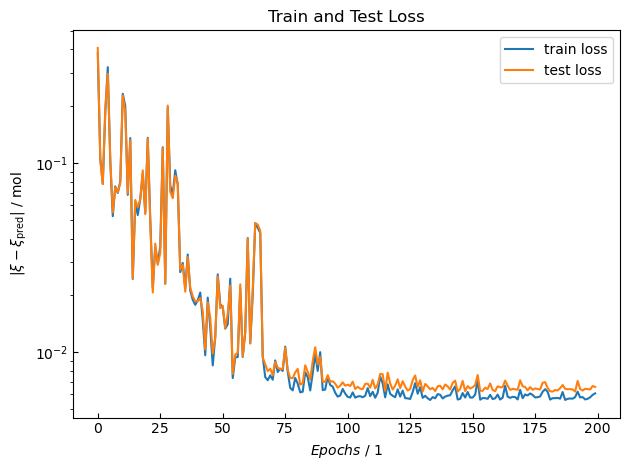

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9637367713973932
Test Dataset: R^2 = 0.9644404939999416
Max Error Training: |xi - xi_pred| = 0.059380106865493665
Max Error Test: |xi - xi_pred| = 0.06416054662635023


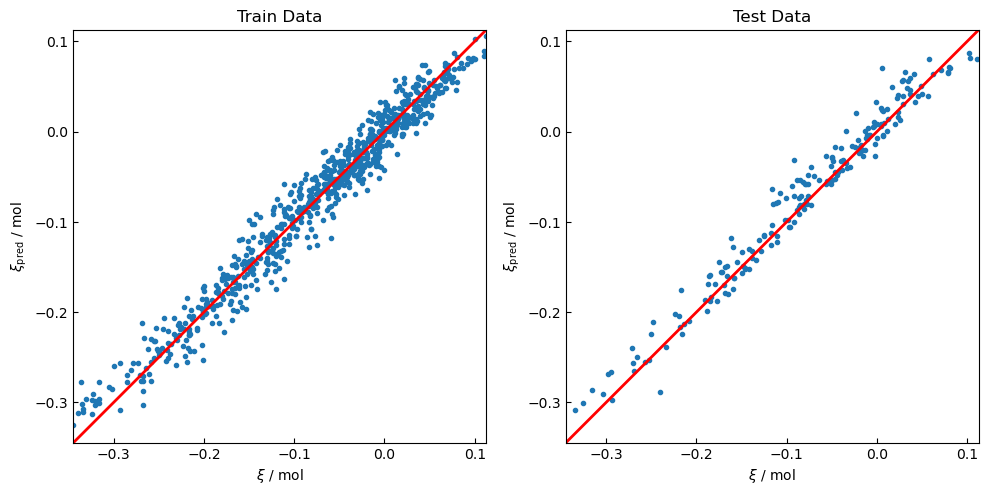

In [21]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))
print('Max Error Training: |xi - xi_pred| =', max_error(xi_real, xi_pred))
print('Max Error Test: |xi - xi_pred| =', max_error(xi_real_test, xi_pred_test))

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

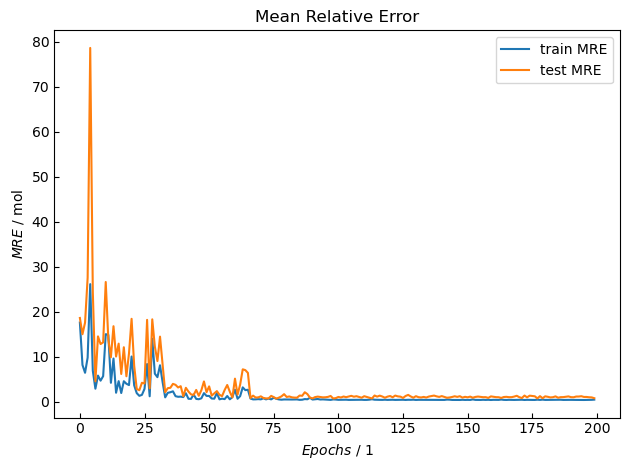

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

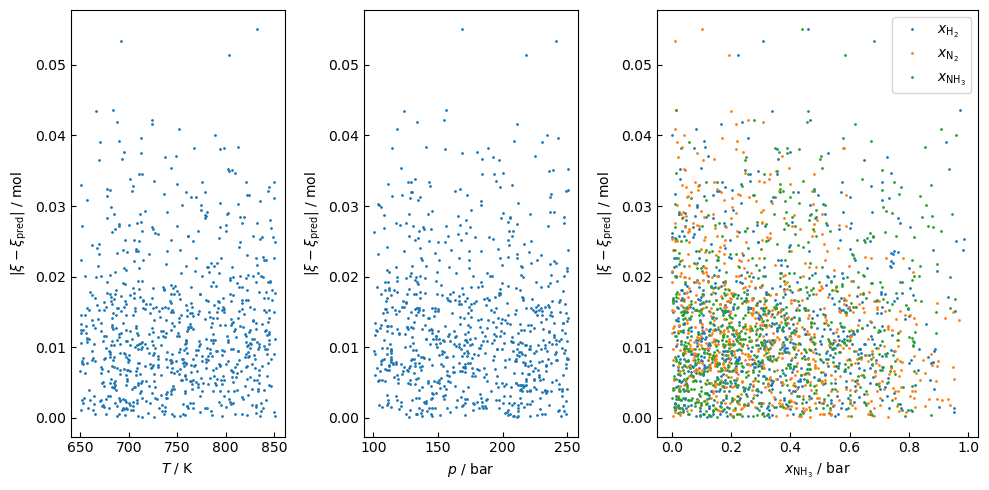

In [13]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

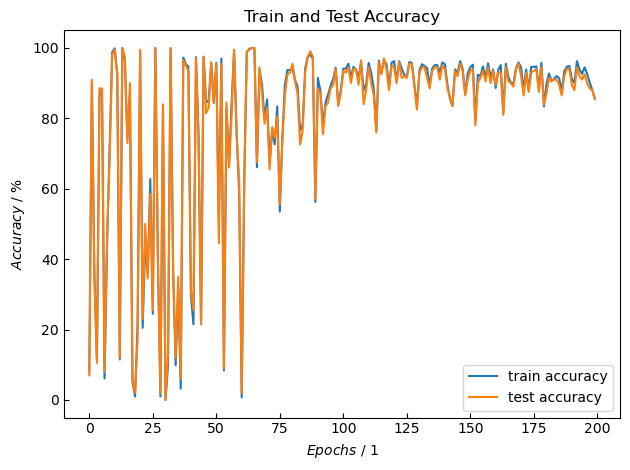

In [14]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [15]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[8.4020e+02, 2.2031e+02, 6.3112e-01, 2.8921e-01, 7.9672e-02],
        [8.3936e+02, 2.2321e+02, 5.7842e-01, 3.3966e-01, 8.1922e-02],
        [7.6421e+02, 1.0920e+02, 9.3405e-02, 7.0932e-01, 1.9728e-01],
        [6.9023e+02, 2.3948e+02, 1.1377e-01, 8.5668e-02, 8.0056e-01],
        [7.3566e+02, 1.9885e+02, 3.7494e-01, 2.7225e-02, 5.9784e-01],
        [8.1704e+02, 1.6808e+02, 6.3295e-01, 3.4629e-01, 2.0763e-02],
        [8.1297e+02, 1.0364e+02, 5.1167e-01, 4.7791e-01, 1.0419e-02],
        [7.1300e+02, 2.0419e+02, 4.0541e-01, 3.0591e-01, 2.8868e-01],
        [6.9327e+02, 1.8414e+02, 3.5900e-01, 1.4118e-01, 4.9982e-01],
        [6.7119e+02, 1.7699e+02, 6.0204e-01, 2.4003e-02, 3.7396e-01],
        [6.8139e+02, 2.3078e+02, 4.9734e-01, 3.5150e-01, 1.5116e-01],
        [7.5012e+02, 1.5677e+02, 2.3388e-01, 4.2237e-01, 3.4375e-01],
        [8.3240e+02, 2.0779e+02, 8.1855e-01, 1.3594e-01, 4.5507e-02],
        [7.3862e+02, 1.2004e+02, 2.1548e-01, 7.6311e-01, 2.1411e-02],
        [7.1221e+02,

#### Einblick in Netzwerk

In [16]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.6893, 0.7130, 0.6907, 0.7377, 0.8219], requires_grad=True),
 Parameter containing:
 tensor([-0.0064,  0.0761, -0.0429, -0.0185,  0.0409], requires_grad=True),
 Parameter containing:
 tensor([[-1.1098e-01,  1.0938e-01, -1.6657e-01,  3.5687e-01,  7.0396e-02],
         [-2.1052e-01, -1.0821e-01,  1.8679e-01, -1.0354e-01,  1.2646e-01],
         [-3.5494e-01,  6.7497e-02, -1.2563e-02, -1.7508e-01,  8.0277e-02],
         [ 5.0044e-02,  1.1675e-02,  2.5384e-01,  2.4854e-01,  2.7033e-01],
         [-2.4646e-01,  3.4843e-01, -7.5524e-02,  1.4986e-01, -2.2757e-01],
         [-1.6967e-02, -1.3910e-01,  1.3345e-02,  6.6807e-02,  8.2652e-02],
         [ 6.8535e-03,  1.7143e-01, -1.0709e-02, -1.7711e-01, -4.6383e-01],
         [-1.6277e-01, -1.6655e-02, -1.6351e-01,  9.5288e-02, -1.0912e-01],
         [ 2.3057e-01, -6.4695e-02, -3.4393e-01, -2.6682e-01, -2.1340e-01],
         [ 1.5599e-01, -1.4599e-01,  1.3585e-01,  4.6979e-03, -1.1945e-01],
         [ 2.5052e-01,  

In [17]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4500, 0.9741, 0.7824, 0.0091, 0.0821],
        [0.4547, 0.5932, 0.8915, 0.2857, 0.6386]])
tensor([[-0.0618],
        [-0.0764]], grad_fn=<AddmmBackward0>)


In [18]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [19]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[8.3133e+02, 2.0189e+02, 3.0774e-01, 6.7303e-01, 1.9231e-02],
        [6.5193e+02, 2.0982e+02, 1.7914e-01, 4.8336e-01, 3.3749e-01],
        [6.8322e+02, 1.7510e+02, 9.4181e-02, 1.6315e-01, 7.4267e-01],
        [8.0253e+02, 2.5075e+02, 2.5699e-02, 3.9738e-02, 9.3456e-01],
        [8.4425e+02, 2.3151e+02, 8.9712e-02, 7.6169e-01, 1.4859e-01],
        [7.7178e+02, 1.3325e+02, 7.4117e-01, 2.6780e-02, 2.3205e-01],
        [8.1459e+02, 1.1318e+02, 7.0946e-01, 8.7186e-03, 2.8182e-01],
        [6.5090e+02, 2.2647e+02, 3.5926e-01, 2.5744e-01, 3.8330e-01],
        [7.7592e+02, 1.0599e+02, 1.0134e-01, 1.4665e-01, 7.5201e-01],
        [6.8139e+02, 2.3078e+02, 4.9734e-01, 3.5150e-01, 1.5116e-01],
        [7.0146e+02, 2.3552e+02, 7.0393e-01, 2.6491e-01, 3.1161e-02],
        [8.1745e+02, 1.4461e+02, 2.3334e-02, 4.6445e-01, 5.1221e-01],
        [7.5613e+02, 2.3753e+02, 8.0149e-01, 1.7264e-01, 2.5869e-02],
        [7.4403e+02, 1.4598e+02, 2.5051e-01, 6.5827e-01, 9.1223e-02],
        [7.6043e+02,

#### Histogramme Verteilung von $xi$ und $x{_i}$

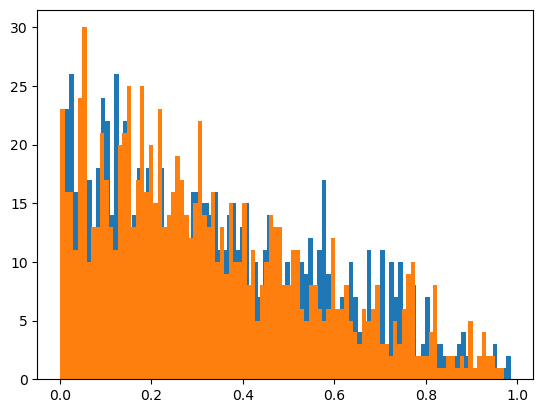

In [20]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()